In this tutorial, we're going to study the K2-24 system, composed of two planets near 2:1 resonance (Petigura et al. 2018). This is an important example because K2 observations will sparsely sample the super-period, likely leading to multimodalities in the posteriors. 

First, we'll set everything up and import ttvnest:

In [1]:
%matplotlib inline
import numpy as np
import ttvnest
import scipy
import time
import multiprocess
from ttvnest.constants import *

Now, let's download the data for Kepler-29 (KOI-738) from the Holczer et al. (2016) catalog:

In [2]:
nplanets = 2
filename = 'k2_24.dat'
data, errs = ttvnest.load_data.get_data_from_file(nplanets, filename)

Reading data from file...
Data retrieved!


Next, we need to define the prior transform. Nested sampling methods typically sample on the unit cube (from 0 to 1 in all dimensions), so we need a way to map that into our preferred prior space. Eventually, I'll try to abstract the prior transform away from the user.

In [3]:
#defining the prior transform

def prior_transform(u):
	x = np.array(u) #copy u
	#planet 1
	x[0] = 40.*u[0] #uniform on [0, 10) earth masses
	x[1] = scipy.stats.norm.ppf(u[1], 20.88, 0.01)  #gaussian around 10.33585 with a width of 0.01
	x[2] = scipy.stats.norm.ppf(u[2], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[3] = scipy.stats.norm.ppf(u[3], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[4] = (u[4] % 1.) * 360. #periodic on [0, 360) degrees
	#planet 2
	x[5] = 40.*u[5] #uniform on [0, 10) earth masses
	x[6] = scipy.stats.norm.ppf(u[6], 42.34, 0.01) #gaussian around 13.29292 with a width of 0.01
	x[7] = scipy.stats.norm.ppf(u[7], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[8] = scipy.stats.norm.ppf(u[8], 0, 0.1) #gaussian around 0 with a width of 0.1
	x[9] = (u[9] % 1.) * 360. #periodic on [0, 360) degrees
	return x

Finally, we sample the posteriors!

In [4]:
poolsize = multiprocess.cpu_count() - 1
with multiprocess.Pool(poolsize) as executor:
    %time results = ttvnest.retrieval.retrieve(nplanets, prior_transform, data, errs, \
                                               pool = executor, queue_size = poolsize, \
                                               start_time = tkep + 2000, sim_length = 200,\
                                               init_live = 5000)

Running dynesty with the rwalk sampler, multi bounding, and 5000 initial live points...


iter: 64212 | batch: 0 | bound: 76 | nc: 25 | ncall: 1350496 | eff(%):  4.737 | loglstar:   -inf < -2685.364 <    inf | logz: -2705.820 +/-  0.040 | dlogz: 2611.746 >  0.010                         /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:237: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 68507 | batch: 0 | bound: 83 | nc: 25 | ncall: 1468915 | eff(%):  4.648 | loglstar:   -inf < -1586.383 <    inf | logz: -1607.516 +/-  0.043 | dlogz: 1581.621 >  0.010                         /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:237: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
iter: 91520 | batch: 0 | bound: 117 | nc: 25 | ncall: 2119017 | eff(%):  4.309 | loglstar:   -inf < -199.746 <    inf | logz: -222.394 +/-  0.050 

CPU times: user 20min 11s, sys: 2min 7s, total: 22min 18s
Wall time: 4h 4min 28s


In [5]:
%time #results = ttvnest.retrieval.retrieve(nplanets, prior_transform, data, errs, start_time = tkep + 2000, sim_length = 200)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


Let's now see a summary of our results:

In [6]:
ttvnest.retrieval.posterior_summary(results)

Summary: 
$M_1/M_\star$: $35.91758278079711^{+2.911222832071381}_{-3.503445213184243}$
$P_1\ [\mathrm{days}]$: $20.883046174369813^{+0.0007248620234499015}_{-0.000849568837594461}$
$e_1\cos(\omega_1)$: $-0.09565454447137561^{+0.005396153783437468}_{-0.0035004080904753043}$
$e_1\sin(\omega_1)$: $0.021356107061961473^{+0.008366543656054107}_{-0.010521728079238468}$
$\mathcal{M}_1\ [^\circ]$: $193.4829032801932^{+4.790585992750778}_{-5.966043260636496}$
$M_2/M_\star$: $34.27337448484748^{+3.8565070421693477}_{-4.4151572121617555}$
$P_2\ [\mathrm{days}]$: $42.37018463515216^{+0.0022277787667519533}_{-0.0020379026559709246}$
$e_2\cos(\omega_2)$: $0.09273300919643196^{+0.004114614233407463}_{-0.0039016961801479344}$
$e_2\sin(\omega_2)$: $-0.04439222655435476^{+0.005743675837542032}_{-0.008133117942046464}$
$\mathcal{M}_2\ [^\circ]$: $331.9332475860446^{+4.537169325586433}_{-3.7113973949485057}$


And let's plot the result, as well as the corner plot, a summary of the run, and the dynesty trace plot.

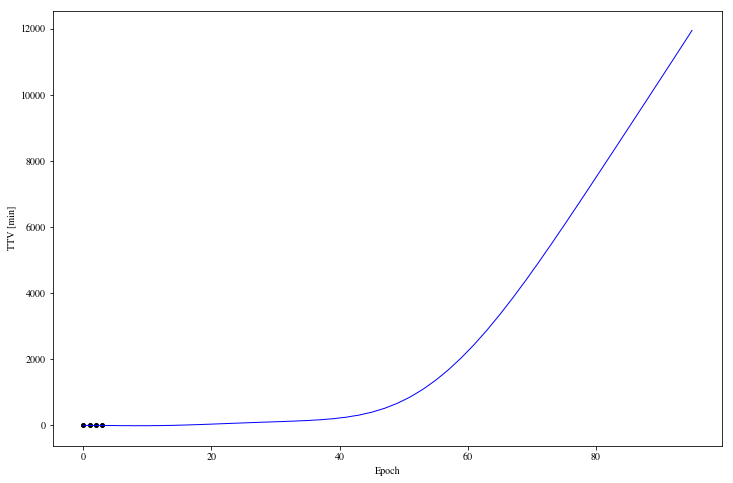

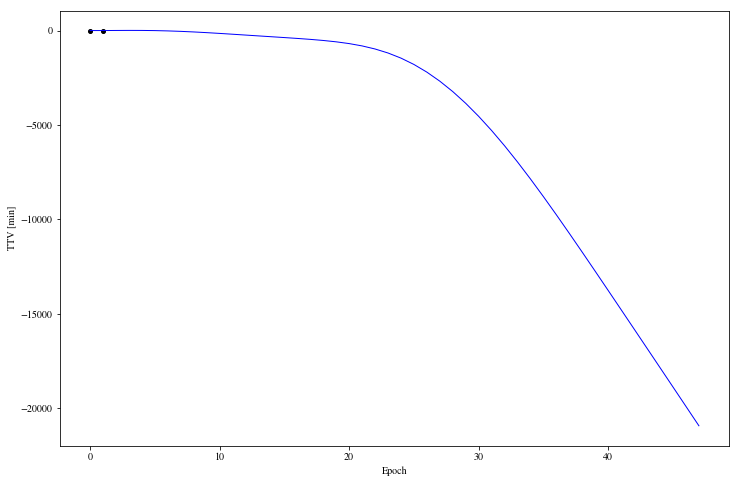

<Figure size 1440x1440 with 0 Axes>

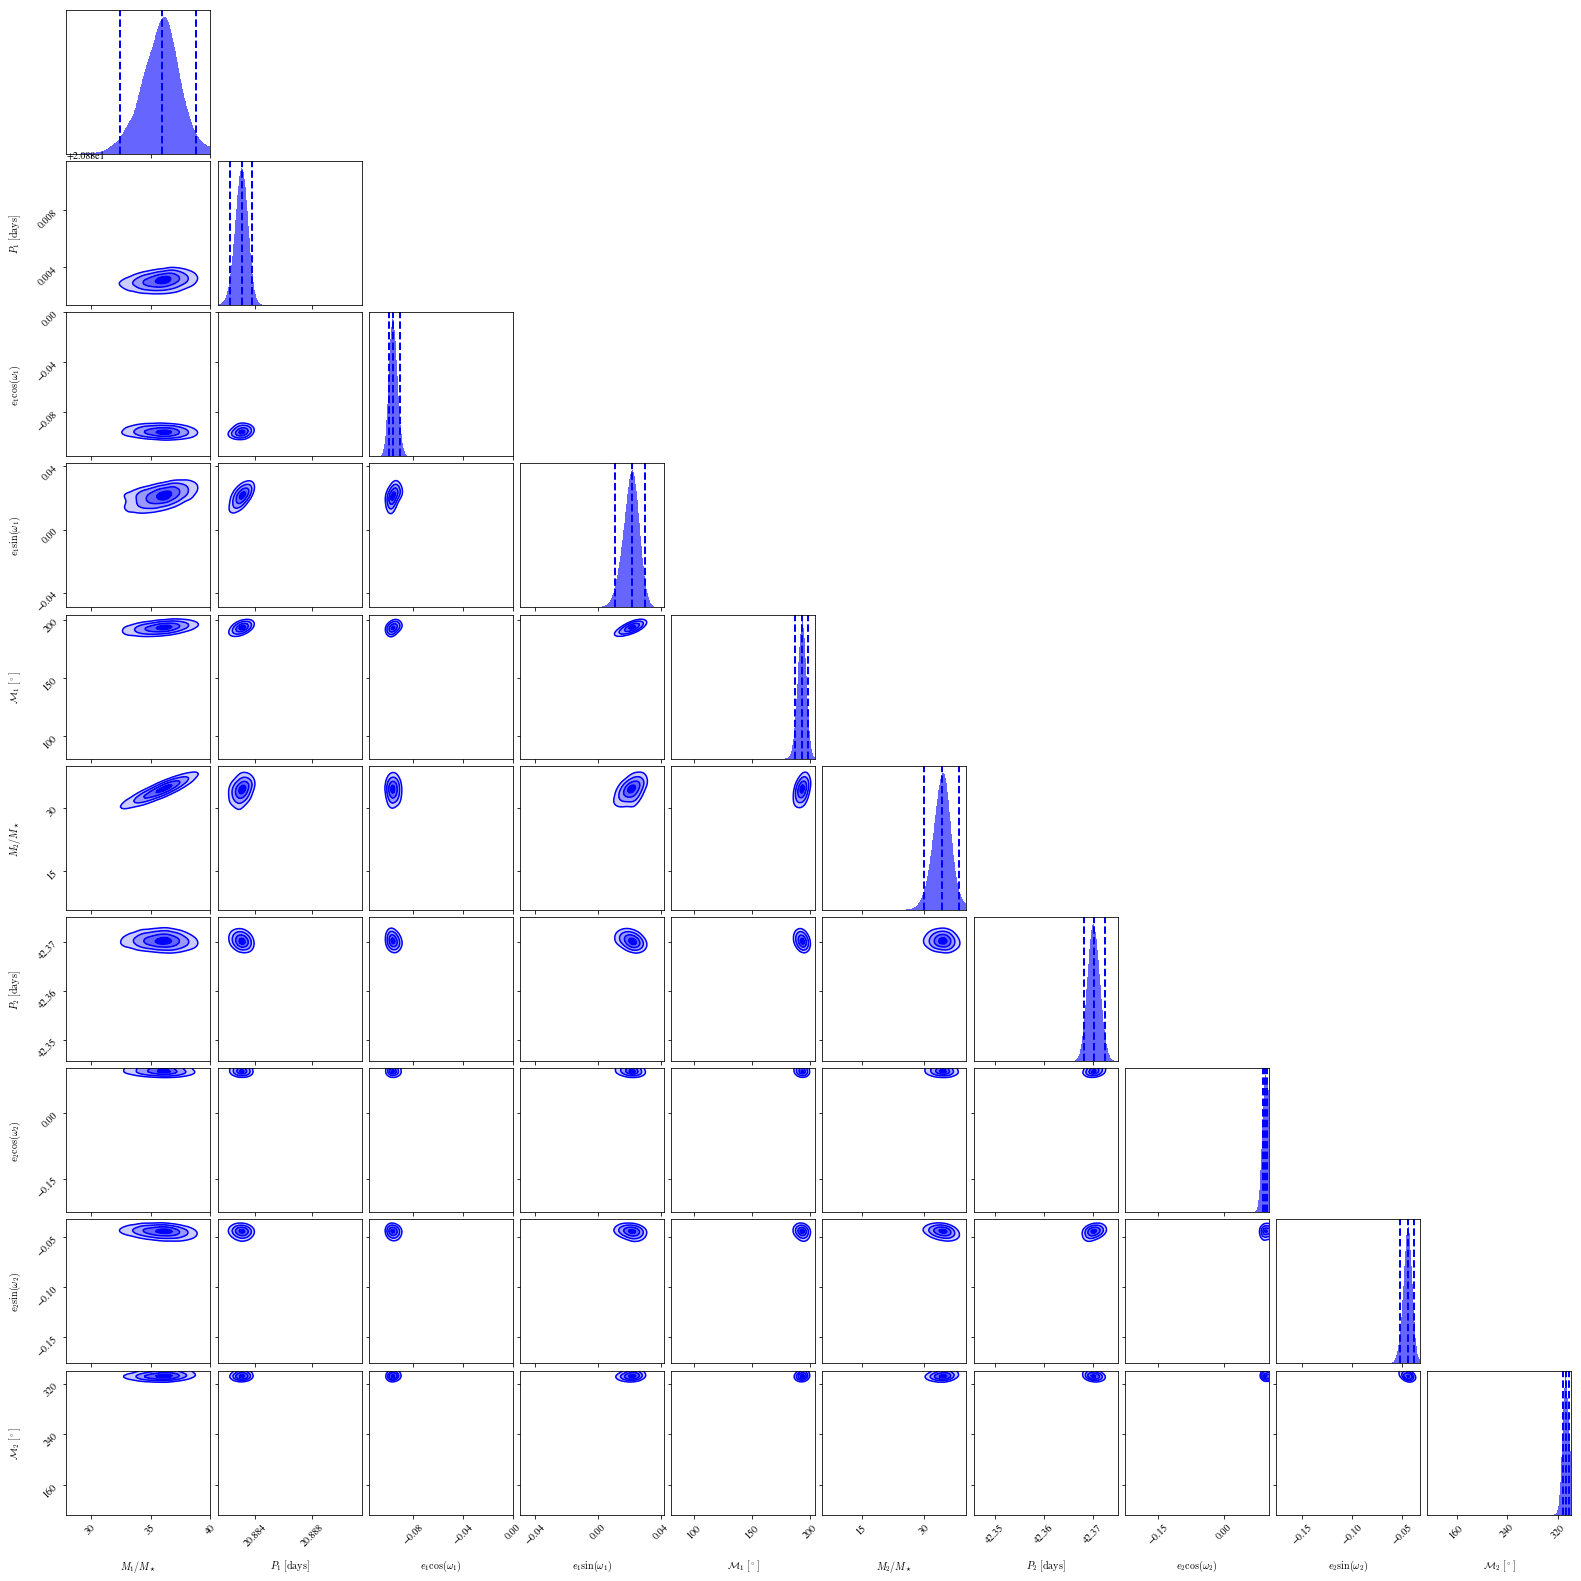

<Figure size 1440x1440 with 0 Axes>

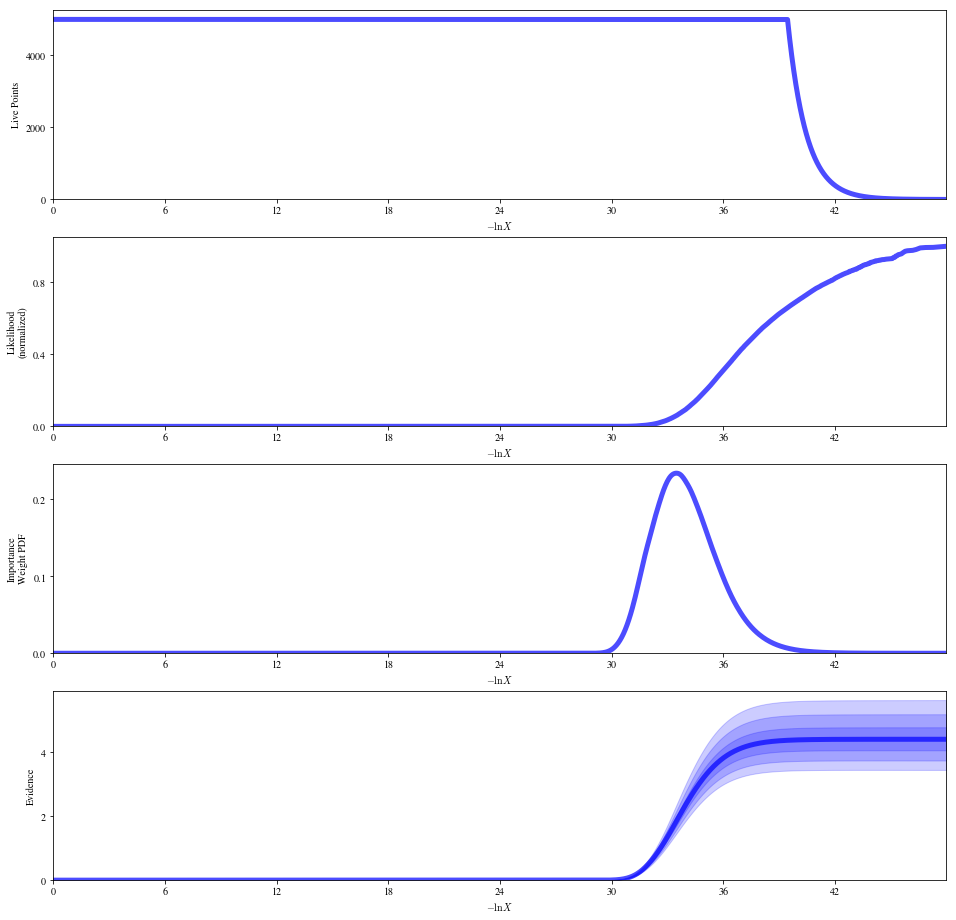

<Figure size 1440x1440 with 0 Axes>

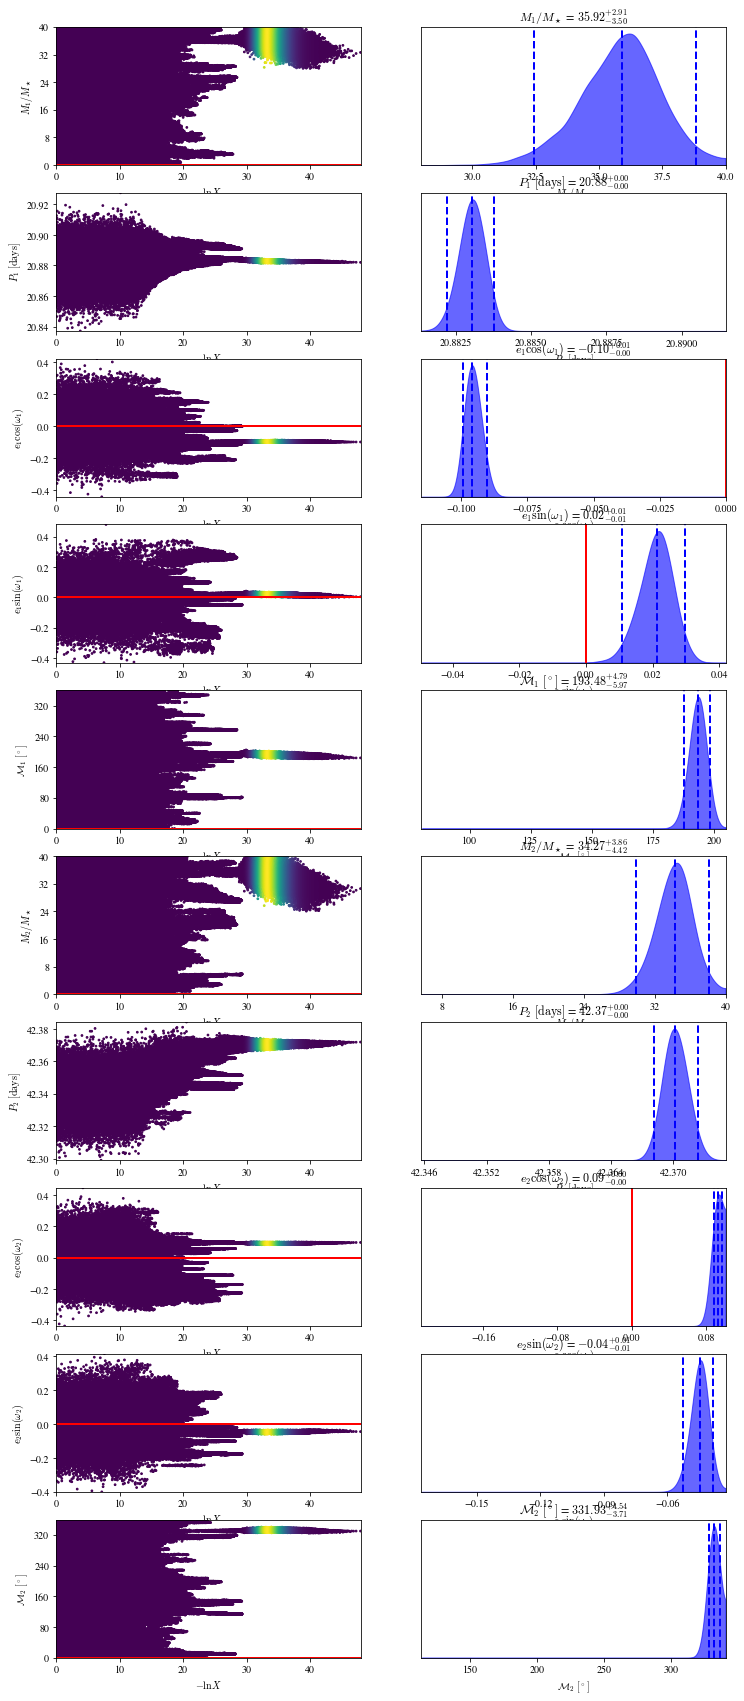

In [8]:
ttvnest.plot_utils.plot_results(results, data, errs, start_time = tkep + 2000)
ttvnest.plot_utils.dynesty_plots(results, nplanets)

Let's make sure to save our results! The results will be saved in a file called 'results.p' by default, but you can change that with the "outname" keyword for save_results.

In [9]:
ttvnest.io_utils.save_results(results, outname = 'results_k2_24.p')

'results_k2_24.p'